In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

In [22]:
def prepare_data(df, target_column='Close', sequence_length=60):
    features = df.drop(columns=[target_column]).values
    target = df[target_column].values

    scaler = MinMaxScaler()

    features_scaled = scaler.fit_transform(features)
    target_scaled = scaler.fit_transform(target.reshape(-1,1))

    X, y = [],[]
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(target_scaled[i,0])

    X, y = np.array(X), np.array(y)

    return X, y, scaler

In [23]:
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    
    # Multi Head Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feedforward Netowrk
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)

    return LayerNormalization(epsilon=1e-6)(x+x_ff)

In [24]:
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)
    x = GlobalAveragePooling1D()(x)
    x = Dense(1)(x)

    model = Model(inputs,x)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

In [25]:
def load_stock_data(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

In [26]:
def train_transformer_model(stock, filepath):
    print(f"Processing {stock} stock.")

    df = load_stock_data(filepath)
    X, y, scaler = prepare_data(df)
    
    train_size = int(len(X)*0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_transformer_model(X_train.shape[1:])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test,y_test),
        epochs=50,
        batch_size= 32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

    mse = tf.keras.losses.MeanSquaredError()(y_test_actual, predictions).numpy()
    r2 = 1-(np.sum((y_test_actual - predictions) ** 2) / np.sum((y_test_actual - np.mean(y_test_actual)) ** 2))

    print(f"Stock: {stock} | MSE: {mse:.5f}, R2: {r2:.5f}")

    plt.figure(figsize=(10,5))
    plt.plot(df.index[-len(y_test_actual):], y_test_actual, label='Actual Close Price', color='blue')
    plt.plot(df.index[-len(y_test_actual):], predictions, label='Predicted Close Price', color='red')
    plt.title(f"{stock} stock price prediction using transformer.")
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

Processing NVIDIA stock.
Epoch 1/50
158/158 [==============================] - 7s 20ms/step - loss: 0.0651 - val_loss: 0.1134 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - 2s 15ms/step - loss: 0.0011 - val_loss: 0.0947 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - 2s 15ms/step - loss: 6.8822e-04 - val_loss: 0.0898 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - 2s 15ms/step - loss: 4.8573e-04 - val_loss: 0.0927 - lr: 0.0010
Epoch 5/50
158/158 [==============================] - 2s 15ms/step - loss: 3.7084e-04 - val_loss: 0.0888 - lr: 0.0010
Epoch 6/50
158/158 [==============================] - 2s 15ms/step - loss: 2.9720e-04 - val_loss: 0.0834 - lr: 0.0010
Epoch 7/50
158/158 [==============================] - 2s 15ms/step - loss: 2.5495e-04 - val_loss: 0.0807 - lr: 0.0010
Epoch 8/50
158/158 [==============================] - 2s 15ms/step - loss: 2.2138e-04 - val_loss: 0.0830 - lr: 0.0010
Epoch 9/50
158/158 [===================

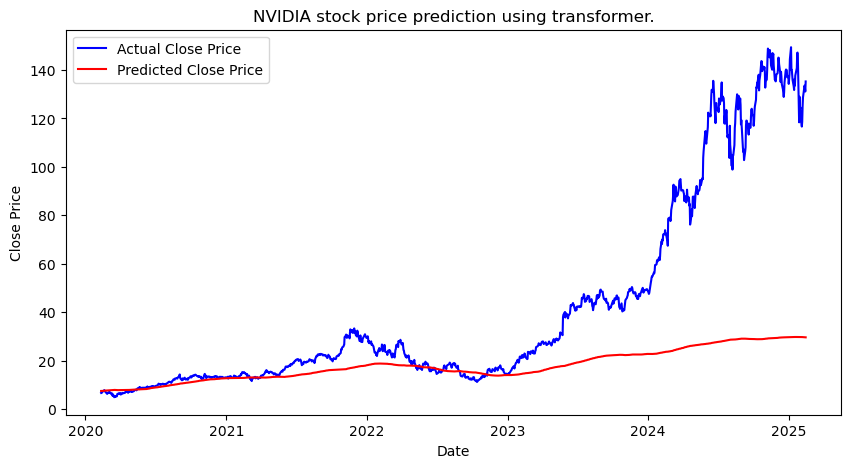

In [27]:
train_transformer_model('NVIDIA', '../data/nvidia_stock_features_selected.csv')

Processing Apple stock.
Epoch 1/50
272/272 [==============================] - 6s 17ms/step - loss: 0.0317 - val_loss: 0.1061 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - 4s 14ms/step - loss: 7.5192e-04 - val_loss: 0.0369 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - 4s 14ms/step - loss: 4.1485e-04 - val_loss: 0.0380 - lr: 0.0010
Epoch 4/50
272/272 [==============================] - 4s 15ms/step - loss: 3.0736e-04 - val_loss: 0.0382 - lr: 0.0010
Epoch 5/50
272/272 [==============================] - 4s 15ms/step - loss: 2.4174e-04 - val_loss: 0.0366 - lr: 0.0010
Epoch 6/50
272/272 [==============================] - 4s 15ms/step - loss: 2.1313e-04 - val_loss: 0.0356 - lr: 0.0010
Epoch 7/50
272/272 [==============================] - 4s 15ms/step - loss: 1.8560e-04 - val_loss: 0.0367 - lr: 0.0010
Epoch 8/50
272/272 [==============================] - 4s 15ms/step - loss: 1.7114e-04 - val_loss: 0.0445 - lr: 0.0010
Epoch 9/50
272/272 [================

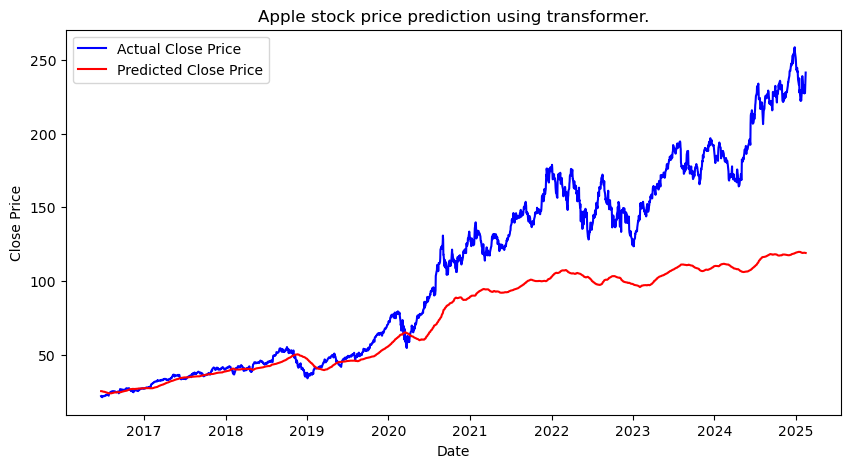

In [28]:
train_transformer_model('Apple', '../data/apple_stock_features_selected.csv')

Processing Microsoft stock.
Epoch 1/50
239/239 [==============================] - 6s 19ms/step - loss: 0.0515 - val_loss: 0.2469 - lr: 0.0010
Epoch 2/50
239/239 [==============================] - 4s 16ms/step - loss: 9.4108e-04 - val_loss: 0.0914 - lr: 0.0010
Epoch 3/50
239/239 [==============================] - 4s 18ms/step - loss: 4.5834e-04 - val_loss: 0.0767 - lr: 0.0010
Epoch 4/50
239/239 [==============================] - 4s 16ms/step - loss: 3.6453e-04 - val_loss: 0.0715 - lr: 0.0010
Epoch 5/50
239/239 [==============================] - 4s 15ms/step - loss: 3.0783e-04 - val_loss: 0.0638 - lr: 0.0010
Epoch 6/50
239/239 [==============================] - 4s 16ms/step - loss: 2.5704e-04 - val_loss: 0.0626 - lr: 0.0010
Epoch 7/50
239/239 [==============================] - 4s 15ms/step - loss: 2.3188e-04 - val_loss: 0.0604 - lr: 0.0010
Epoch 8/50
239/239 [==============================] - 4s 16ms/step - loss: 1.9636e-04 - val_loss: 0.0593 - lr: 0.0010
Epoch 9/50
239/239 [============

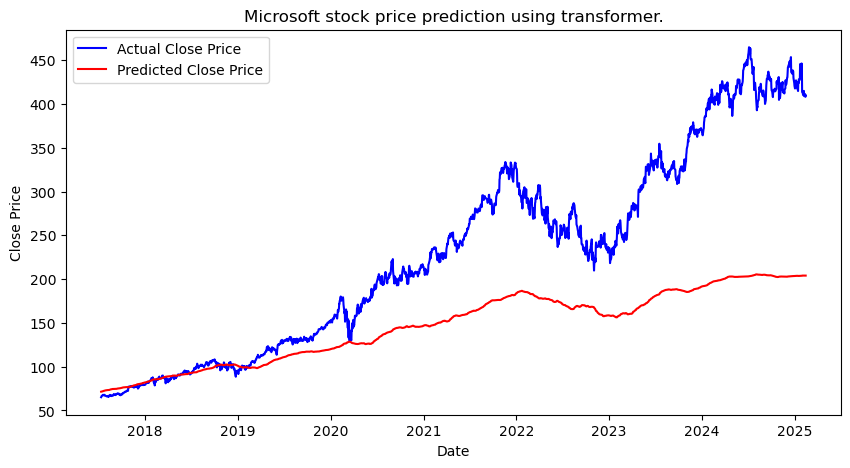

In [29]:
train_transformer_model('Microsoft', '../data/microsoft_stock_features_selected.csv')

As expected Multi Headed transformers may not capture the full variability of our dataset let's move on with our multivariate model instead.